# Introduction

This notebook is divided into three sections.

1) **Train and validation split** - takes all of the images in `images_for_model` folder and splits them into test and validation sets. This creates a new folder, `images_for_model_split`.
2) **Training the model** - loads all the data from `images_for_model_split` and trains the model. Saves the model to `resnet_model.pt`.
3) **Loading the trained model and evaluating it** - loads only the validation data from `images_for_model_split` and the model from `resnet_model.pt`. Draws the confusion matrix.

If the model file exists in `resnet_model.pt` then the second section can be omitted next time you open the notebook.

# Train and validation split

All of the images are in the folder `ORIGINAL_DIR`. The file names contain class labels in their file names, separated by underscores. We have attached different types of labels for them, but now we are only interested in "crack" vs not "crack". To split them into training and validation sets, this kind of directory structure is needed:

```
DATA_DIR
|
|___train
|   |
|   |___working
|   |
|   |___crack
|
|___val
    |
    |___working
    |
    |___crack
```

In [3]:
ORIGINAL_DIR = "images_for_model"
DATA_DIR = "images_for_model_split"

WORKING = "working"
CRACK = "crack"

In [4]:
def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        if item != ".ipynb_checkpoints":
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                result.extend(collect_file_paths(item_path, ext))
            elif item_path.endswith(ext):
                result.append(item_path)
                
    return result

In [5]:
def split_files(image_paths, working_dir, crack_dir):
    for path in image_paths:
        file_name = path.split("/")[-1]
        file_labels = file_name.split("_")

        if CRACK in file_labels:
            shutil.copyfile(path, os.path.join(crack_dir, file_name))
        elif not ("lcd" in file_labels):
            shutil.copyfile(path, os.path.join(working_dir, file_name))
            
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)

TRAIN_WORKING = os.path.join(DATA_DIR, "train", WORKING)
TRAIN_CRACK = os.path.join(DATA_DIR, "train", CRACK)
VAL_WORKING = os.path.join(DATA_DIR, "val", WORKING)
VAL_CRACK = os.path.join(DATA_DIR, "val", CRACK)

os.makedirs(TRAIN_WORKING)
os.makedirs(TRAIN_CRACK)
os.makedirs(VAL_WORKING)
os.makedirs(VAL_CRACK)

all_images = collect_file_paths(ORIGINAL_DIR, ".jpeg")
shuffle(all_images)
n_train = int(0.8 * len(all_images))

train_images = all_images[:n_train]
val_images = all_images[n_train:]

split_files(all_images[:n_train], TRAIN_WORKING, TRAIN_CRACK)
split_files(all_images[n_train:], VAL_WORKING, VAL_CRACK)

## Show how many examples we have for each class

In [6]:
n_train_working = len(os.listdir(TRAIN_WORKING))
n_train_crack = len(os.listdir(TRAIN_CRACK))

n_val_working = len(os.listdir(VAL_WORKING))
n_val_crack = len(os.listdir(VAL_CRACK))

print("-------------")

print("Train images:")
print(WORKING + ": ", n_train_working)
print(CRACK + ": ", n_train_crack)
print("Total: ", n_train_working + n_train_crack)
      
print("-------------")

print("Validation images:")
print(WORKING + ": ", n_val_working)
print(CRACK + ": ", n_val_crack)
print("Total: ", n_val_working + n_val_crack)
      
print("-------------")

-------------
Train images:
working:  104
crack:  89
Total:  193
-------------
Validation images:
working:  28
crack:  22
Total:  50
-------------


# Training the model

Most of the code in this part of the notebook is taken from [pytorch docs](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Imports

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
import os
import copy
import shutil
from random import shuffle

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load data

In [7]:
IMAGE_HEIGHT = 3024
IMAGE_WIDTH = 4032

resize = (IMAGE_HEIGHT // 10, IMAGE_WIDTH // 10)

color_channel_mean = [0.485, 0.456, 0.406]
color_channel_std = [0.229, 0.224, 0.225]

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(color_channel_mean, color_channel_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize(color_channel_mean, color_channel_std)
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4,
                                              shuffle = True, num_workers = 2)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cpu") # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

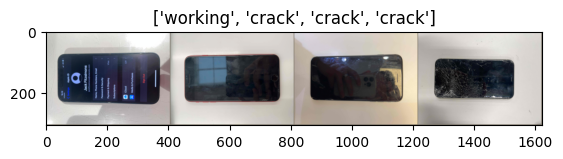

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Function to train the model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Load a pretrained model and reset final fully connected layer.

In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/gpfs/space/home/kermos/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/space/home/kermos/my_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train and save the model to file

In [13]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7055 Acc: 0.5803
val Loss: 0.9170 Acc: 0.5200

Epoch 1/24
----------
train Loss: 0.5239 Acc: 0.7824
val Loss: 0.8821 Acc: 0.7400

Epoch 2/24
----------
train Loss: 0.4370 Acc: 0.7927
val Loss: 0.6010 Acc: 0.7200

Epoch 3/24
----------
train Loss: 0.4146 Acc: 0.8238
val Loss: 0.5447 Acc: 0.8400

Epoch 4/24
----------
train Loss: 0.3182 Acc: 0.8601
val Loss: 0.7440 Acc: 0.7000

Epoch 5/24
----------
train Loss: 0.7752 Acc: 0.7565
val Loss: 0.6079 Acc: 0.8000

Epoch 6/24
----------
train Loss: 0.4998 Acc: 0.8342
val Loss: 1.0953 Acc: 0.6600

Epoch 7/24
----------
train Loss: 0.4324 Acc: 0.8238
val Loss: 0.4586 Acc: 0.8200

Epoch 8/24
----------
train Loss: 0.2806 Acc: 0.8653
val Loss: 0.4450 Acc: 0.8200

Epoch 9/24
----------
train Loss: 0.2485 Acc: 0.8912
val Loss: 0.5117 Acc: 0.7600

Epoch 10/24
----------
train Loss: 0.1595 Acc: 0.9378
val Loss: 0.4743 Acc: 0.8600

Epoch 11/24
----------
train Loss: 0.2530 Acc: 0.8860
val Loss: 0.4506 Acc: 0.8600

Ep

In [14]:
torch.save(model_ft, "resnet_model.pt")

# Load the trained model and evaluating it

The following section assumes that the model was saved to `MODEL_FILE`. Also, this kind of directory structure is needed for data:

```
DATA_DIR
|
|___working
|
|___crack
```

In [ ]:
import torch
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = "images_for_model_split/val"
MODEL_FILE = "resnet_model.py"

In [ ]:
IMAGE_HEIGHT = 3024
IMAGE_WIDTH = 4032

resize = (IMAGE_HEIGHT // 10, IMAGE_WIDTH // 10)

color_channel_mean = [0.485, 0.456, 0.406]
color_channel_std = [0.229, 0.224, 0.225]

In [ ]:
model_ft = torch.load(MODEL_FILE)

# Data augmentation and normalization for training
# Just normalization for validation

data_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(color_channel_mean, color_channel_std)
])

image_dataset = datasets.ImageFolder(
    DATA_DIR, 
    data_transform
)

dataloader = torch.utils.data.DataLoader(
    image_dataset, 
    batch_size = 4, 
    shuffle = True, 
    num_workers = 2
)

dataset_size = len(image_dataset)

class_names = image_dataset.classes

device = torch.device("cpu") # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def predict(model, dataloader):
    was_training = model.training
    model.eval()
    
    actual = []
    predicted = []
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            actual.extend(labels)
            predicted.extend(preds)
                
        model.train(mode=was_training)
        
    return actual, predicted

In [18]:
# Also taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def visualize_predictions(model, dataloader, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'actual: {class_names[labels[j]]}, predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

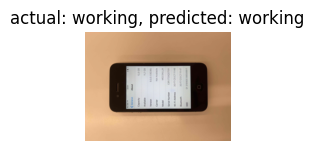

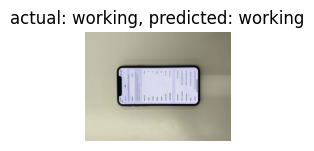

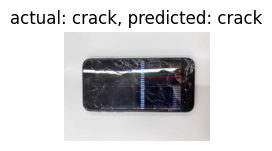

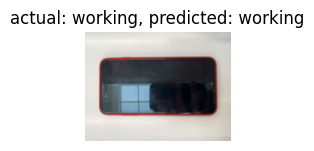

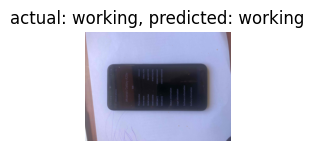

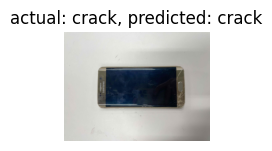

In [19]:
visualize_predictions(model_ft, dataloader)

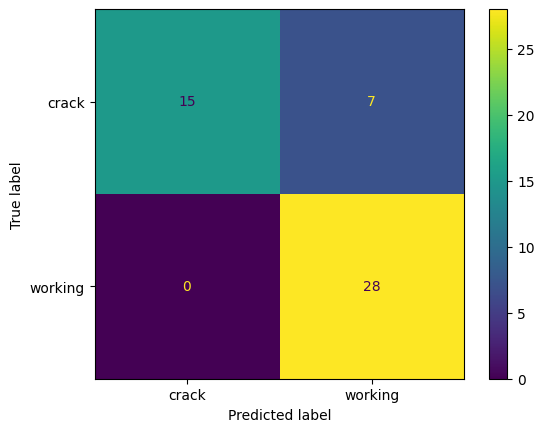

In [26]:
actual, predicted = predict(model_ft, dataloader)
cm = confusion_matrix(actual, predicted)

disp = ConfusionMatrixDisplay(
    confusion_matrix = cm, 
    display_labels = class_names
)
disp.plot()
plt.show()